In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
# fix random seed for reproducibility
np.random.seed(7)

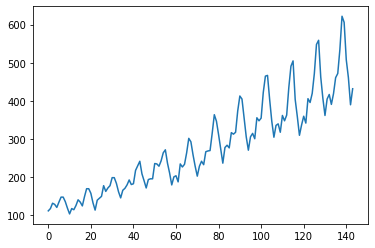

In [3]:
dataframe = pandas.read_csv('data/airline-passengers.csv', usecols=[1], engine='python')
plt.plot(dataframe)
plt.show()

In [4]:
array = dataframe['Passengers'].to_numpy().astype('float32')
n_samples = len(array)
array

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.], dtype=float32)

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
normalized_array = scaler.fit_transform(array.reshape(-1, 1)).reshape(-1)
normalized_array

array([0.01544401, 0.02702703, 0.05405405, 0.04826255, 0.03281853,
       0.05984557, 0.08494207, 0.08494207, 0.06177607, 0.02895753,
       0.        , 0.02702703, 0.02123553, 0.04247104, 0.07142857,
       0.05984557, 0.04054055, 0.08687258, 0.12741312, 0.12741312,
       0.10424709, 0.05598456, 0.01930502, 0.06949806, 0.07915059,
       0.08880308, 0.14285713, 0.11389962, 0.13127413, 0.14285713,
       0.18339768, 0.18339768, 0.15444016, 0.11196911, 0.08108109,
       0.1196911 , 0.12934363, 0.14671814, 0.17181468, 0.14864865,
       0.15250966, 0.22007722, 0.24324325, 0.26640925, 0.2027027 ,
       0.16795367, 0.13127413, 0.17374519, 0.17760617, 0.17760617,
       0.25482625, 0.25289574, 0.24131274, 0.26833975, 0.3088803 ,
       0.32432434, 0.25675675, 0.20656371, 0.14671814, 0.18725869,
       0.19305018, 0.16216215, 0.25289574, 0.23745173, 0.25096524,
       0.3088803 , 0.38223937, 0.36486486, 0.2992278 , 0.24131274,
       0.1911197 , 0.24131274, 0.26640925, 0.24903473, 0.31467

In [6]:
# split into train and test sets
train_size = int(n_samples * 0.67)
test_size = n_samples - train_size
train, test = normalized_array[:train_size], normalized_array[train_size:]
print(len(train), len(test))

96 48


In [7]:
def rolling_window(a: np.array, window: int) -> np.array:
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [8]:
input_size = 12
train_x_2d = rolling_window(train, input_size)[:-1]  # We don't have the label for the last sequence so we discard it
test_x_2d = rolling_window(test, input_size)[:-1]
print(len(train_x_2d), len(test_x_2d))

84 36


In [9]:
train_y = train[input_size:]
test_y = test[input_size:]
print(len(train_y), len(test_y))

84 36


In [10]:
train_x_2d

array([[0.01544401, 0.02702703, 0.05405405, ..., 0.02895753, 0.        ,
        0.02702703],
       [0.02702703, 0.05405405, 0.04826255, ..., 0.        , 0.02702703,
        0.02123553],
       [0.05405405, 0.04826255, 0.03281853, ..., 0.02702703, 0.02123553,
        0.04247104],
       ...,
       [0.32818535, 0.25675675, 0.3359073 , ..., 0.5965251 , 0.58108103,
        0.484556  ],
       [0.25675675, 0.3359073 , 0.34749034, ..., 0.58108103, 0.484556  ,
        0.3899614 ],
       [0.3359073 , 0.34749034, 0.33397684, ..., 0.484556  , 0.3899614 ,
        0.3223938 ]], dtype=float32)

In [11]:
# reshape input to be [samples, time steps, features]
train_x_3d = np.reshape(train_x_2d, (train_x_2d.shape[0], train_x_2d.shape[1], 1))
test_x_3d = np.reshape(test_x_2d, (test_x_2d.shape[0], test_x_2d.shape[1], 1))
train_x_3d

array([[[0.01544401],
        [0.02702703],
        [0.05405405],
        ...,
        [0.02895753],
        [0.        ],
        [0.02702703]],

       [[0.02702703],
        [0.05405405],
        [0.04826255],
        ...,
        [0.        ],
        [0.02702703],
        [0.02123553]],

       [[0.05405405],
        [0.04826255],
        [0.03281853],
        ...,
        [0.02702703],
        [0.02123553],
        [0.04247104]],

       ...,

       [[0.32818535],
        [0.25675675],
        [0.3359073 ],
        ...,
        [0.5965251 ],
        [0.58108103],
        [0.484556  ]],

       [[0.25675675],
        [0.3359073 ],
        [0.34749034],
        ...,
        [0.58108103],
        [0.484556  ],
        [0.3899614 ]],

       [[0.3359073 ],
        [0.34749034],
        [0.33397684],
        ...,
        [0.484556  ],
        [0.3899614 ],
        [0.3223938 ]]], dtype=float32)

In [12]:
def evaluate_model(model, input_3d=True):
    if input_3d:
        train_x = train_x_3d
        test_x = test_x_3d
    else:
        train_x = train_x_2d
        test_x = test_x_2d
    
    # make predictions
    train_predict = scaler.inverse_transform(model.predict(train_x, batch_size=1))
    test_predict = scaler.inverse_transform(model.predict(test_x, batch_size=1))
    train_y_inverted = scaler.inverse_transform([train_y])
    test_y_inverted = scaler.inverse_transform([test_y])
    # calculate root mean squared error
    train_rmse = math.sqrt(mean_squared_error(train_y_inverted[0], train_predict[:,0]))
    print('Train Score: %.2f RMSE' % (train_rmse))
    test_rmse = math.sqrt(mean_squared_error(test_y_inverted[0], test_predict[:,0]))
    print('Test Score: %.2f RMSE' % (test_rmse))
    train_predict_plot = np.empty_like(array.reshape(-1, 1))
    train_predict_plot[:, :] = np.nan
    train_predict_plot[input_size:len(train_predict)+input_size, :] = train_predict
    # shift test predictions for plotting
    test_predict_plot = np.empty_like(array.reshape(-1, 1))
    test_predict_plot[:, :] = np.nan
    test_predict_plot[len(train_predict)+(input_size*2):len(array), :] = test_predict
    return train_predict_plot, test_predict_plot

In [13]:
# Shallow narrow LSTM network
lstm1 = Sequential()
lstm1.add(LSTM(1))
lstm1.add(Dense(1))
lstm1.compile(loss='mean_squared_error', optimizer='adam')
lstm1.fit(train_x_3d, train_y, epochs=500, batch_size=1, verbose=0)

In [14]:
# Shallow wide (10 units) LSTM network
lstm2 = Sequential()
lstm2.add(LSTM(10))
lstm2.add(Dense(1))
lstm2.compile(loss='mean_squared_error', optimizer='adam')
lstm2.fit(train_x_3d, train_y, epochs=500, batch_size=1, verbose=0)

In [15]:
# Stacked narrow LSTM network
lstm3 = Sequential()
lstm3.add(LSTM(1, return_sequences=True))
lstm3.add(LSTM(1))
lstm3.add(Dense(1))
lstm3.compile(loss='mean_squared_error', optimizer='adam')
lstm3.fit(train_x_3d, train_y, epochs=500, batch_size=1, verbose=0)

In [16]:
# Stacked wide (10 units) LSTM network
lstm4 = Sequential()
lstm4.add(LSTM(10, return_sequences=True))
lstm4.add(LSTM(10))
lstm4.add(Dense(1))
lstm4.compile(loss='mean_squared_error', optimizer='adam')
lstm4.fit(train_x_3d, train_y, epochs=500, batch_size=1, verbose=0)

In [17]:
# Linear transformation (+ bias)
nonrec1 = Sequential()
nonrec1.add(Dense(1))
nonrec1.compile(loss='mean_squared_error', optimizer='adam')
nonrec1.fit(train_x_2d, train_y, epochs=500, batch_size=1, verbose=0)

In [18]:
# 1 hidden layer with 10 neurons, ReLU
nonrec2 = Sequential()
nonrec2.add(Dense(10, activation='relu'))
nonrec2.add(Dense(1))
nonrec2.compile(loss='mean_squared_error', optimizer='adam')
nonrec2.fit(train_x_2d, train_y, epochs=500, batch_size=1, verbose=0)

In [19]:
# 2 hidden layers with 10 neurons each, ReLU
nonrec3 = Sequential()
nonrec3.add(Dense(10, activation='relu'))
nonrec3.add(Dense(10, activation='relu'))
nonrec3.add(Dense(1))
nonrec3.compile(loss='mean_squared_error', optimizer='adam')
nonrec3.fit(train_x_2d, train_y, epochs=500, batch_size=1, verbose=0)

In [20]:
# 3 hidden layers with 25 neurons each, ReLU
nonrec4 = Sequential()
nonrec4.add(Dense(25, activation='relu'))
nonrec4.add(Dense(25, activation='relu'))
nonrec4.add(Dense(25, activation='relu'))
nonrec4.add(Dense(1))
nonrec4.compile(loss='mean_squared_error', optimizer='adam')
nonrec4.fit(train_x_2d, train_y, epochs=500, batch_size=1, verbose=0)

In [21]:
train_predict_plot_lstm1, test_predict_plot_lstm1 = evaluate_model(lstm1, input_3d=True)

Train Score: 24.44 RMSE
Test Score: 65.33 RMSE


In [22]:
train_predict_plot_lstm2, test_predict_plot_lstm2 = evaluate_model(lstm2, input_3d=True)

Train Score: 11.38 RMSE
Test Score: 88.47 RMSE


In [23]:
train_predict_plot_lstm3, test_predict_plot_lstm3 = evaluate_model(lstm3, input_3d=True)

Train Score: 18.33 RMSE
Test Score: 54.44 RMSE


In [24]:
train_predict_plot_lstm4, test_predict_plot_lstm4 = evaluate_model(lstm4, input_3d=True)

Train Score: 13.03 RMSE
Test Score: 168.33 RMSE


In [25]:
train_predict_plot_nonrec1, test_predict_plot_nonrec1 = evaluate_model(nonrec1, input_3d=False)

Train Score: 11.70 RMSE
Test Score: 27.98 RMSE


In [26]:
train_predict_plot_nonrec2, test_predict_plot_nonrec2 = evaluate_model(nonrec2, input_3d=False)

Train Score: 10.19 RMSE
Test Score: 17.99 RMSE


In [27]:
train_predict_plot_nonrec3, test_predict_plot_nonrec3 = evaluate_model(nonrec3, input_3d=False)

Train Score: 8.22 RMSE
Test Score: 27.73 RMSE


In [28]:
train_predict_plot_nonrec4, test_predict_plot_nonrec4 = evaluate_model(nonrec4, input_3d=False)

Train Score: 10.54 RMSE
Test Score: 30.26 RMSE


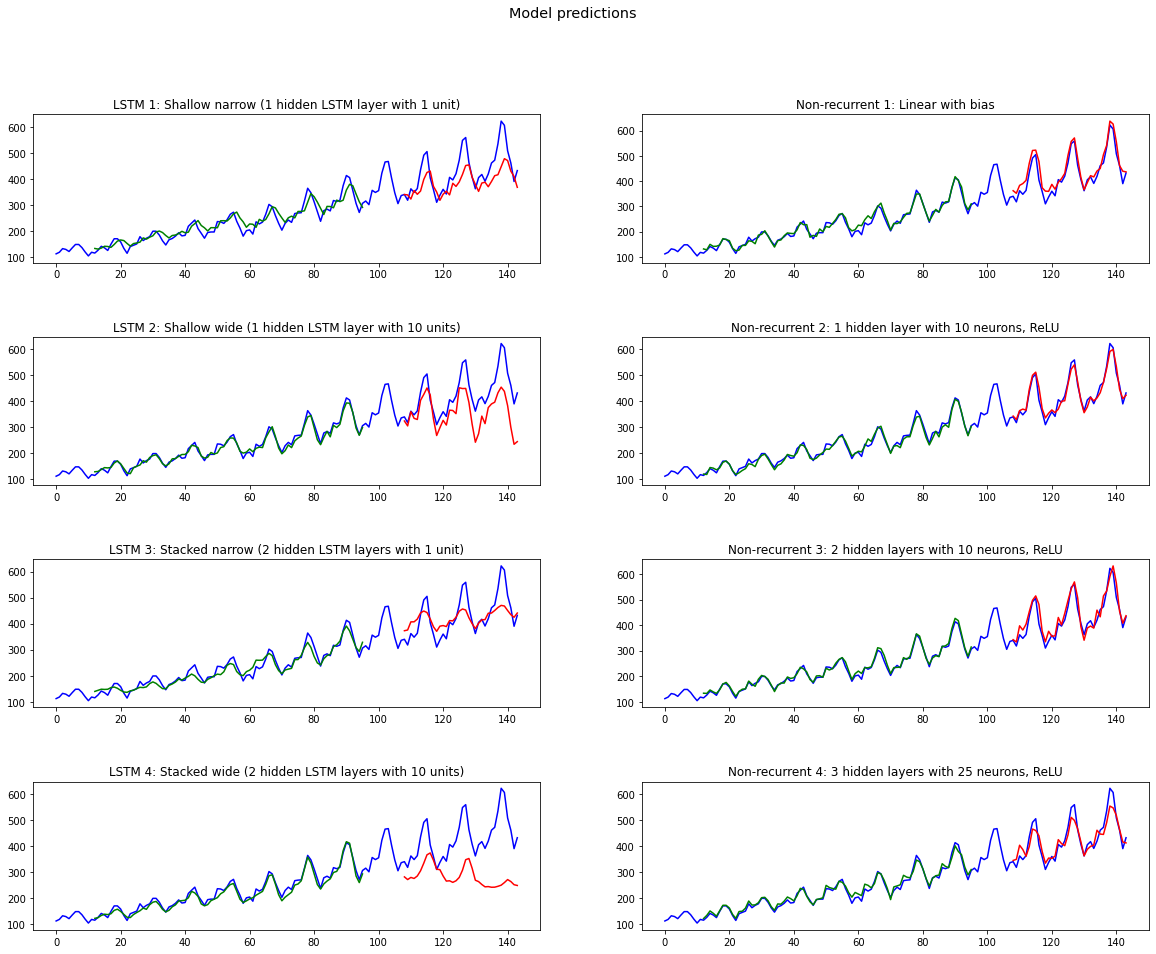

In [30]:
fig, axs = plt.subplots(4, 2, figsize=(20, 15), gridspec_kw={'hspace': 0.5})
fig.suptitle('Model predictions', size='x-large')
axs[0, 0].plot(array, color='blue')
axs[0, 0].plot(train_predict_plot_lstm1, color='green')
axs[0, 0].plot(test_predict_plot_lstm1, color='red')
axs[0, 0].set_title('LSTM 1: Shallow narrow (1 hidden LSTM layer with 1 unit)')

axs[1, 0].plot(array, color='blue')
axs[1, 0].plot(train_predict_plot_lstm2, color='green')
axs[1, 0].plot(test_predict_plot_lstm2, color='red')
axs[1, 0].set_title('LSTM 2: Shallow wide (1 hidden LSTM layer with 10 units)')

axs[2, 0].plot(array, color='blue')
axs[2, 0].plot(train_predict_plot_lstm3, color='green')
axs[2, 0].plot(test_predict_plot_lstm3, color='red')
axs[2, 0].set_title('LSTM 3: Stacked narrow (2 hidden LSTM layers with 1 unit)')

axs[3, 0].plot(array, color='blue')
axs[3, 0].plot(train_predict_plot_lstm4, color='green')
axs[3, 0].plot(test_predict_plot_lstm4, color='red')
axs[3, 0].set_title('LSTM 4: Stacked wide (2 hidden LSTM layers with 10 units)')

axs[0, 1].plot(array, color='blue')
axs[0, 1].plot(train_predict_plot_nonrec1, color='green')
axs[0, 1].plot(test_predict_plot_nonrec1, color='red')
axs[0, 1].set_title('Non-recurrent 1: Linear with bias')

axs[1, 1].plot(array, color='blue')
axs[1, 1].plot(train_predict_plot_nonrec2, color='green')
axs[1, 1].plot(test_predict_plot_nonrec2, color='red')
axs[1, 1].set_title('Non-recurrent 2: 1 hidden layer with 10 neurons, ReLU')

axs[2, 1].plot(array, color='blue')
axs[2, 1].plot(train_predict_plot_nonrec3, color='green')
axs[2, 1].plot(test_predict_plot_nonrec3, color='red')
axs[2, 1].set_title('Non-recurrent 3: 2 hidden layers with 10 neurons, ReLU')

axs[3, 1].plot(array, color='blue')
axs[3, 1].plot(train_predict_plot_nonrec4, color='green')
axs[3, 1].plot(test_predict_plot_nonrec4, color='red')
axs[3, 1].set_title('Non-recurrent 4: 3 hidden layers with 25 neurons, ReLU')

plt.show()